# **Pokémon Diffusion<a id="top"></a>**

> #### ``04-Training-Diffusion-Model.ipynb``

<i><small>**Alumno:** Alejandro Pequeño Lizcano<br>Última actualización: 20/05/2024</small></i></div>

TODO: INTRODUCIR MEJOR

Como paso final, se procede a entrenar el modelo de difusión. Para ello, se ha definido la función ``training()`` que engloba todo el proceso de difusión completo, tanto hacia adelante como hacia atrás y los ploteos de las muestras generadas. Para implementar el training hemos usado el **Algoritmo 1** de [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) y se ha modificado para que sea capaz de generar imágenes condicionadas a una etiqueta.

<div style="text-align:center">
<img src="../figures/notebook_figures/algorithm1_training.png" width="40%" height="30%" />
</div>

También se han añadido unas funcionalidades extra que permiten guardar cada epoch el modelo y sus pesos en un fichero con extensión .h5. Esto se hace para poder cargar el modelo y continuar el entrenamiento desde donde se quedó en caso de que se interrumpa por algún motivo.

><span style="color: red; font-size: 1.5em;">&#9888;</span> <i><small>**NOTA:** Por cada epoch se guarda en un fichero con extensión .h5 tanto el modelo como sus pesos. Este proceso se realiza ya que todo el entrenamiento es muy costoso y si se interrumpe por algún motivo, se puede volver a cargar el modelo y continuar el entrenamiento desde donde se quedó.
>
>También cabe destacar que para una mayor eficiencia en el entrenamiento, se ha optado por realizar el ``sampling()`` cada 20 epochs.
</small></i>

# 0. Imports

In [1]:
# Import necessary libraries
# =====================================================================
import tensorflow as tf
import configparser
from src.model.build_model import build_unet
from src.utils import *
from src.utils.config import parse_config
from src.visualization import visualize
from src.model.diffusion_funcionality import *
from src.model.model_callbacks import *

2024-05-26 11:59:54.304813: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-26 11:59:54.335302: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-26 11:59:55.601436: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-26 11:59:55.605177: I external/local_xla/x

In [2]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(CONFIG_PATH)

hyperparameters = parse_config(config, "hyperparameters")

IMG_SIZE = hyperparameters["img_size"]
NUM_CLASSES = hyperparameters["num_classes"]
BATCH_SIZE = hyperparameters["batch_size"]
EPOCHS = hyperparameters["epochs"]

TIMESTEPS = hyperparameters["timesteps"]
SCHEDULER = hyperparameters["scheduler"]
BETA_START = hyperparameters["beta_start"]
BETA_END = hyperparameters["beta_end"]
S = hyperparameters["s"]

# 1. Dataset

- The shape of the dataset is: (64, 64, 64, 3) => batch_size: 64, height: 64, width: 64, channels: 3
- The shape of the dataset labels is: (64, 18) => batch_size: 64, number of labels: 18


2024-05-26 11:59:56.311855: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


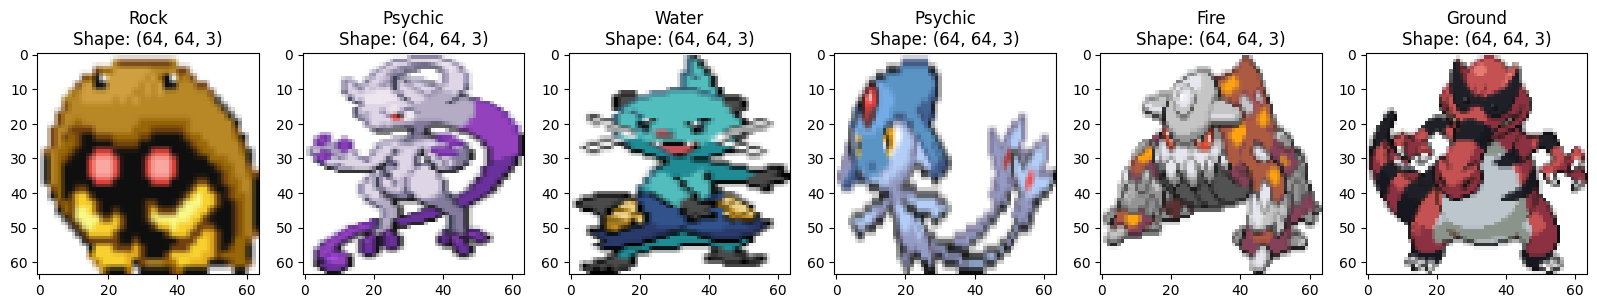

2024-05-26 11:59:57.255572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset/size{IMG_SIZE}x{IMG_SIZE}_batch{BATCH_SIZE}"
poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(dataset_tf=poke_dataset, n=6)

# 2. Model

In [5]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, TIMESTEPS, BETA_START, BETA_END, S, "linear"
)

# wasserstein_loss = WassersteinLoss()

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer, metrics=["accuracy"])

## 2.1. Training

Epoch 1/500


I0000 00:00:1716724810.670396   38352 service.cc:145] XLA service 0x718c280028b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716724810.670421   38352 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-05-26 12:00:11.077556: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1716724811.622332   38352 random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform
2024-05-26 12:00:12.511004: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1716724814.457248   38709 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_11', 12 byte

63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 261ms/step - accuracy: 0.5008 - loss: 1.0242
Epoch 2/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 262ms/step - accuracy: 0.7994 - loss: 0.2498
Epoch 3/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 263ms/step - accuracy: 0.8479 - loss: 0.1779
Epoch 4/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 264ms/step - accuracy: 0.8696 - loss: 0.1506
Epoch 5/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 265ms/step - accuracy: 0.8828 - loss: 0.1311
Epoch 6/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 265ms/step - accuracy: 0.8918 - loss: 0.1127
Epoch 7/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 265ms/step - accuracy: 0.8933 - loss: 0.1134
Epoch 8/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 266ms/step - accuracy: 0.9048 - loss: 0.0933
Epoch 9/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 265ms/step - accuracy: 0.9089 - loss: 0.0882
Epoch 10/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 265ms/step - accuracy: 0.9138 - loss: 0.0819
Epoch 11/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 266ms/step - accuracy: 0.9141 - loss: 0.0836
Epoch 12/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17

Sampling sprite...: 100%|██████████| 1000/1000 [01:31<00:00, 10.97it/s]


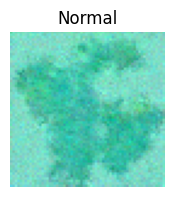

63/63 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.9304 - loss: 0.0650 
Epoch 21/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 260ms/step - accuracy: 0.9320 - loss: 0.0646
Epoch 22/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 260ms/step - accuracy: 0.9327 - loss: 0.0638
Epoch 23/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 261ms/step - accuracy: 0.9348 - loss: 0.0608
Epoch 24/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 261ms/step - accuracy: 0.9366 - loss: 0.0590
Epoch 25/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 262ms/step - accuracy: 0.9356 - loss: 0.0615
Epoch 26/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 262ms/step - accuracy: 0.9374 - loss: 0.0589
Epoch 27/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 262ms/step - accuracy: 0.9383 - loss: 0.0589
Epoch 28/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 262ms/step - accuracy: 0.9397 - loss: 0.0571
Epoch 29/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 262ms/step - accuracy: 0.9395 - loss: 0.0583
Epoch 30/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 262ms/step - accuracy: 0.9389 - loss: 0.0592
Epoch 31/500
63/63 ━━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 1000/1000 [01:27<00:00, 11.44it/s]


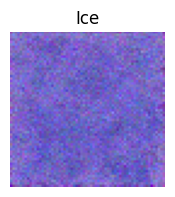

63/63 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.9445 - loss: 0.0549 
Epoch 41/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 258ms/step - accuracy: 0.9463 - loss: 0.0520
Epoch 42/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 260ms/step - accuracy: 0.9479 - loss: 0.0497
Epoch 43/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 260ms/step - accuracy: 0.9454 - loss: 0.0548
Epoch 44/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 261ms/step - accuracy: 0.9466 - loss: 0.0533
Epoch 45/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 261ms/step - accuracy: 0.9467 - loss: 0.0524
Epoch 46/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 261ms/step - accuracy: 0.9472 - loss: 0.0522
Epoch 47/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 261ms/step - accuracy: 0.9490 - loss: 0.0489
Epoch 48/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 262ms/step - accuracy: 0.9498 - loss: 0.0484
Epoch 49/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 262ms/step - accuracy: 0.9498 - loss: 0.0495
Epoch 50/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 262ms/step - accuracy: 0.9488 - loss: 0.0518
Epoch 51/500
63/63 ━━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 1000/1000 [01:27<00:00, 11.49it/s]


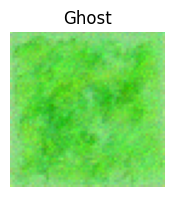

63/63 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.9510 - loss: 0.0500 
Epoch 61/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 259ms/step - accuracy: 0.9534 - loss: 0.0456
Epoch 62/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 260ms/step - accuracy: 0.9530 - loss: 0.0469
Epoch 63/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 260ms/step - accuracy: 0.9530 - loss: 0.0471
Epoch 64/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 261ms/step - accuracy: 0.9534 - loss: 0.0467
Epoch 65/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 261ms/step - accuracy: 0.9530 - loss: 0.0475
Epoch 66/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 262ms/step - accuracy: 0.9529 - loss: 0.0480
Epoch 67/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 262ms/step - accuracy: 0.9558 - loss: 0.0426
Epoch 68/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 262ms/step - accuracy: 0.9548 - loss: 0.0452
Epoch 69/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 262ms/step - accuracy: 0.9525 - loss: 0.0499
Epoch 70/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 262ms/step - accuracy: 0.9539 - loss: 0.0473
Epoch 71/500
63/63 ━━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 1000/1000 [01:31<00:00, 10.96it/s]


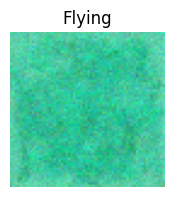

63/63 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.9560 - loss: 0.0448 
Epoch 81/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 260ms/step - accuracy: 0.9563 - loss: 0.0443
Epoch 82/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 261ms/step - accuracy: 0.9558 - loss: 0.0450
Epoch 83/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 262ms/step - accuracy: 0.9558 - loss: 0.0463
Epoch 84/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 262ms/step - accuracy: 0.9533 - loss: 0.0508
Epoch 85/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 262ms/step - accuracy: 0.9566 - loss: 0.0448
Epoch 86/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 263ms/step - accuracy: 0.9570 - loss: 0.0439
Epoch 87/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 263ms/step - accuracy: 0.9575 - loss: 0.0431
Epoch 88/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 263ms/step - accuracy: 0.9571 - loss: 0.0438
Epoch 89/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 263ms/step - accuracy: 0.9566 - loss: 0.0446
Epoch 90/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 263ms/step - accuracy: 0.9566 - loss: 0.0451
Epoch 91/500
63/63 ━━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 1000/1000 [01:29<00:00, 11.20it/s]


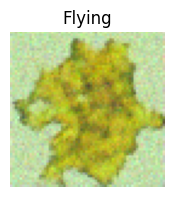

63/63 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.9575 - loss: 0.0443 
Epoch 101/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 260ms/step - accuracy: 0.9581 - loss: 0.0437
Epoch 102/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 260ms/step - accuracy: 0.9593 - loss: 0.0418
Epoch 103/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 261ms/step - accuracy: 0.9562 - loss: 0.0474
Epoch 104/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 262ms/step - accuracy: 0.9582 - loss: 0.0433
Epoch 105/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 262ms/step - accuracy: 0.9580 - loss: 0.0439
Epoch 106/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 262ms/step - accuracy: 0.9584 - loss: 0.0435
Epoch 107/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 263ms/step - accuracy: 0.9591 - loss: 0.0422
Epoch 108/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 263ms/step - accuracy: 0.9600 - loss: 0.0407
Epoch 109/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 263ms/step - accuracy: 0.9600 - loss: 0.0412
Epoch 110/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 263ms/step - accuracy: 0.9589 - loss: 0.0423
Epoch 111/500
63/63 ━━━━━

Sampling sprite...: 100%|██████████| 1000/1000 [01:32<00:00, 10.81it/s]


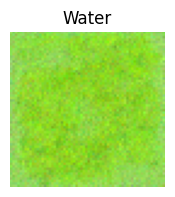

63/63 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.9597 - loss: 0.0417 
Epoch 121/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 260ms/step - accuracy: 0.9589 - loss: 0.0442
Epoch 122/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 261ms/step - accuracy: 0.9593 - loss: 0.0431
Epoch 123/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 262ms/step - accuracy: 0.9602 - loss: 0.0418
Epoch 124/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 262ms/step - accuracy: 0.9603 - loss: 0.0416
Epoch 125/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 263ms/step - accuracy: 0.9599 - loss: 0.0429
Epoch 126/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 263ms/step - accuracy: 0.9614 - loss: 0.0397
Epoch 127/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 263ms/step - accuracy: 0.9590 - loss: 0.0437
Epoch 128/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 263ms/step - accuracy: 0.9596 - loss: 0.0419
Epoch 129/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 263ms/step - accuracy: 0.9599 - loss: 0.0406
Epoch 130/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 263ms/step - accuracy: 0.9607 - loss: 0.0411
Epoch 131/500
63/63 ━━━━━

Sampling sprite...: 100%|██████████| 1000/1000 [01:29<00:00, 11.13it/s]


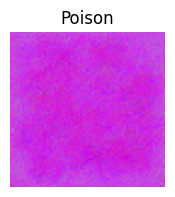

63/63 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.9603 - loss: 0.0419 
Epoch 141/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 260ms/step - accuracy: 0.9612 - loss: 0.0410
Epoch 142/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 260ms/step - accuracy: 0.9605 - loss: 0.0421
Epoch 143/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 261ms/step - accuracy: 0.9612 - loss: 0.0410
Epoch 144/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 262ms/step - accuracy: 0.9627 - loss: 0.0382
Epoch 145/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 262ms/step - accuracy: 0.9632 - loss: 0.0373
Epoch 146/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 262ms/step - accuracy: 0.9626 - loss: 0.0380
Epoch 147/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 262ms/step - accuracy: 0.9627 - loss: 0.0388
Epoch 148/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 262ms/step - accuracy: 0.9589 - loss: 0.0454
Epoch 149/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 263ms/step - accuracy: 0.9615 - loss: 0.0404
Epoch 150/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 262ms/step - accuracy: 0.9620 - loss: 0.0400
Epoch 151/500
63/63 ━━━━━

In [6]:
model.fit(poke_dataset, epochs=EPOCHS, callbacks=[DiffusionCallback(model, 20)])

## 2.2. Results and save model

In [ ]:
# Sample some sprites
# =====================================================================
model.plot_samples(6)

In [ ]:
# Save the model
# =====================================================================
# model.save(f"{MODELS_PATH}/diffusion_model") TODO: TBC

[BACK TO TOP](#top)